In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import os
import random
import matplotlib.pyplot as plt

cuda_available = torch.cuda.is_available()

In [2]:
START_YEAR = 1992
END_YEAR = 2020
HEM = 'sh'
VERSION = 'v2'

PATH_SOURCE = "/home/jbassham/jack/data/sh/inputs"
PATH_DEST = "/home/jbassham/jack/data/sh/outputs"

In [3]:
# Set random seed for reproducibility

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False     

set_seed(42)

In [5]:
# Load input variable file
fnam = f'inputs_normalized_{HEM}_{START_YEAR}_{END_YEAR}.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam))

# Unpack input variables from .npz file
uit = data['uitn']
vit = data['vitn']
uwt = data['uwtn']
vwt = data['vwtn']
icy = data['icyn']

# Pack input variables into list
invars = [uit, vit, uwt, vwt, icy]

print("Input Variables Loaded")

# Get landmask (where always nan) (USE LATER FOR PLOTTING!)
land_mask = np.all(np.isnan(uit), axis = 0)

# Convert NaN values in inputs to zero
invars = [np.nan_to_num(var, 0) for var in invars]

# Unpack variables
uit, vit, uwt, vwt, icy = invars

print("Input Variables Processed")

# Extract time (dates)
fnam = f"time_today_{HEM}_{START_YEAR}_{END_YEAR}.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
tt = data['time_today']

print("Time Loaded")

# Latitude Longitude Grid for plotting
fnam = f'lat_lon_{HEM}.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam))
lat = data['lat']
lon = data['lon']

print("Lat Lon Loaded")

print("Other Variables Loaded")

Input Variables Loaded
Input Variables Processed
Time Loaded
Lat Lon Loaded
Other Variables Loaded


In [7]:
# Use cuda if available
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
    print('Using CUDA')
else:
    device = torch.device("cpu")
    print('USING CPU')

# Get dimensions
nt, ny, nx = np.shape(uit) # time, latitude, longitude

# Define number of input channels
n_in = 3

# Define number of output channels
n_out = 2


# Initialize PyTorch Tensors (batch, channels, height, width)
x = torch.zeros((nt, n_in, ny, nx), dtype = torch.float32, device = device) # Features
y = torch.zeros((nt, n_out, ny, nx), dtype = torch.float32, device = device) # Targets

# Fill feature arrays
x[:, 0, :, :] = torch.from_numpy(uwt).to(device) # Zonal Wind, Today
x[:, 1, :, :] = torch.from_numpy(vwt).to(device) # Meridional Wind, Today
x[:, 2, :, :] = torch.from_numpy(icy).to(device) # Ice Concentration, Yesterday

# Fill target arrays
y[:, 0, :, :] = torch.from_numpy(uit).to(device) # Zonal Ice Velocity, Today
y[:, 1, :, :] = torch.from_numpy(vit).to(device) # Meridional Ice Velocity, Today

print("Arrays filled")

USING CPU
Arrays filled


In [8]:
years = tt.astype('datetime64[Y]').astype(int) + 1970

# Define ranges
train_mask = (years >= 1992) & (years <= 2016)
val_mask   = (years >= 2017) & (years <= 2018)
test_mask  = (years >= 2019) & (years <= 2020)

# Get indices
train_idx = np.where(train_mask)[0]
val_idx   = np.where(val_mask)[0]
test_idx  = np.where(test_mask)[0]

print('Data should be shaped: (nt, n_channels,ny,nx)')

x_train, y_train = x[train_idx], y[train_idx]
print(f'x_train.shape{x_train.shape}')
print(f'y_train.shape{y_train.shape}')
x_val, y_val     = x[val_idx], y[val_idx]
print(f'x_val.shape{x_val.shape}')
print(f'y_val.shape{y_val.shape}')
x_test, y_test   = x[test_idx], y[test_idx]
print(f'x_test.shape{x_val.shape}')
print(f'y_test.shape{y_val.shape}')


x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]
x_test, y_test = x[test_idx], y[test_idx]
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

batch_size = 365 # 365, Hoffman

# Create Tensor Datasets
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
valData = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=True)

print("trainData, valData, testData; created")

Data should be shaped: (nt, n_channels,ny,nx)
x_train.shapetorch.Size([9131, 3, 81, 522])
y_train.shapetorch.Size([9131, 2, 81, 522])
x_val.shapetorch.Size([730, 3, 81, 522])
y_val.shapetorch.Size([730, 2, 81, 522])
x_test.shapetorch.Size([730, 3, 81, 522])
y_test.shapetorch.Size([730, 2, 81, 522])
torch.Size([9131, 3, 81, 522]) torch.Size([9131, 2, 81, 522])
torch.Size([730, 3, 81, 522]) torch.Size([730, 2, 81, 522])
torch.Size([731, 3, 81, 522]) torch.Size([731, 2, 81, 522])
trainData, valData, testData; created


In [9]:
class CNN(nn.Module):
    """
    CNN architecture taken directly from Hoffman et al. (2023)
    
    """

    def __init__(self, in_channels, out_channels, height, width):
        super().__init__()

        self.out_channels = out_channels
        self.height = height
        self.width = width

        # Convolutional layers
        self.layer1 = nn.Conv2d(in_channels, 7, kernel_size=3, stride=1, padding='same')
        self.layer2 = nn.Conv2d(7, 14, kernel_size=3, stride=1, padding='same')
        self.layer3 = nn.Conv2d(14, 28, kernel_size=3, stride=1, padding='same')
        self.layer4 = nn.Conv2d(28, 56, kernel_size=3, stride=1, padding='same')
        self.layer5 = nn.Conv2d(56, 112, kernel_size=3, stride=1, padding='same')

        # Pooling, activation, dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

        # Dynamically compute flattened size using dummy input
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, height, width)
            dummy_out = self.forward_features(dummy_input)
            flat_size = dummy_out.view(1, -1).shape[1]

        # Final fully connected layer
        self.fc = nn.Linear(flat_size, out_channels * height * width)

    def forward_features(self, x):
        x = self.relu(self.layer1(x))
        x = self.pool(x)
        x = self.relu(self.layer2(x))
        x = self.pool(x)
        x = self.relu(self.layer3(x))
        x = self.pool(x)
        x = self.relu(self.layer4(x))
        x = self.pool(x)
        x = self.relu(self.layer5(x))
        x = self.pool(x)
        x = self.dropout(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = x.view(-1, self.out_channels, self.height, self.width)
        return x

In [10]:
weight_decay = 1e-4 # L2 Norm Regularization, changed from 0.01 in TensorFlow
# NOTE TensorFLow multiplies Regularization by 0.05 0.01*0.05 -> 5e-4
lr = 1e-4 # learning rate, changed from 1e-3 in TensorFlow

# Complile model
model = CNN(n_in, n_out, ny, nx).to(device)

print('model compiled')

# Apply Xavier initialization to match TensorFlow default
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

print('Xavier initialization complete')

# NOTE l2 normalization gets added in the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=weight_decay)

num_epochs = 50 # Hoffman

model compiled
Xavier initialization complete


In [11]:
# Define NRMSE Loss
def NRMSEloss(pred, true, eps=1e-6):
    mse = torch.mean((pred - true) ** 2)
    std = torch.std(true, unbiased = False) + eps # Unbiased=True To match default pop. std. in tf 
    return torch.sqrt(mse) / std


In [12]:
from tqdm import tqdm

num_epochs = 50 # Hoffman

# Initialize losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in tqdm(trainData, desc=f"Train Epoch {epoch+1}/{num_epochs}", leave=False):
        # print(torch.isnan(xb).any(), torch.isinf(xb).any())
        optimizer.zero_grad()
        preds = model(xb)
        loss = NRMSEloss(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    for xb, yb in tqdm(valData, desc=f"Val   Epoch {epoch+1}/{num_epochs}", leave=False):
        with torch.no_grad():
            preds = model(xb)
            loss = NRMSEloss(preds, yb)
            val_loss += loss.item()

    avg_train = train_loss / len(trainData)
    avg_val   = val_loss   / len(valData)

    
    train_losses.append(avg_train)
    val_losses.append(avg_val)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train:.4f} - Val Loss: {avg_val:.4f}")

# Save model weights

fnam = f'CNNweights{HEM}{START_YEAR}{END_YEAR}{VERSION}.pth'
torch.save(model.state_dict(), os.path.join(PATH_DEST,fnam))

Epoch 1/50 - Train Loss: 0.9991 - Val Loss: 1.0014


Epoch 2/50 - Train Loss: 0.9895 - Val Loss: 0.9795


Epoch 3/50 - Train Loss: 0.9300 - Val Loss: 0.9105


Epoch 4/50 - Train Loss: 0.8666 - Val Loss: 0.8520


Epoch 5/50 - Train Loss: 0.8259 - Val Loss: 0.8193


Epoch 6/50 - Train Loss: 0.7974 - Val Loss: 0.7872


Epoch 7/50 - Train Loss: 0.7751 - Val Loss: 0.7782


Epoch 8/50 - Train Loss: 0.7658 - Val Loss: 0.7643


Epoch 9/50 - Train Loss: 0.7591 - Val Loss: 0.7550


Epoch 10/50 - Train Loss: 0.7503 - Val Loss: 0.7541


Epoch 11/50 - Train Loss: 0.7514 - Val Loss: 0.7446


Epoch 12/50 - Train Loss: 0.7460 - Val Loss: 0.7478


Epoch 13/50 - Train Loss: 0.7410 - Val Loss: 0.7451


Epoch 14/50 - Train Loss: 0.7392 - Val Loss: 0.7354


Epoch 15/50 - Train Loss: 0.7372 - Val Loss: 0.7381


Epoch 16/50 - Train Loss: 0.7334 - Val Loss: 0.7360


Epoch 17/50 - Train Loss: 0.7358 - Val Loss: 0.7372


Epoch 18/50 - Train Loss: 0.7322 - Val Loss: 0.7307


Epoch 19/50 - Train Loss: 0.7285 - Val Loss: 0.7331


Epoch 20/50 - Train Loss: 0.7229 - Val Loss: 0.7313


Epoch 21/50 - Train Loss: 0.7246 - Val Loss: 0.7306


Epoch 22/50 - Train Loss: 0.7261 - Val Loss: 0.7292


Epoch 23/50 - Train Loss: 0.7285 - Val Loss: 0.7280


Epoch 24/50 - Train Loss: 0.7306 - Val Loss: 0.7376


Epoch 25/50 - Train Loss: 0.7176 - Val Loss: 0.7264


Epoch 26/50 - Train Loss: 0.7186 - Val Loss: 0.7288


Epoch 27/50 - Train Loss: 0.7195 - Val Loss: 0.7247


Epoch 28/50 - Train Loss: 0.7142 - Val Loss: 0.7205


Epoch 29/50 - Train Loss: 0.7160 - Val Loss: 0.7199


Epoch 30/50 - Train Loss: 0.7186 - Val Loss: 0.7272


Epoch 31/50 - Train Loss: 0.7147 - Val Loss: 0.7296


Epoch 32/50 - Train Loss: 0.7161 - Val Loss: 0.7234


Epoch 33/50 - Train Loss: 0.7122 - Val Loss: 0.7226


Epoch 34/50 - Train Loss: 0.7128 - Val Loss: 0.7202


Epoch 35/50 - Train Loss: 0.7128 - Val Loss: 0.7203


Epoch 36/50 - Train Loss: 0.7050 - Val Loss: 0.7198


Epoch 37/50 - Train Loss: 0.7134 - Val Loss: 0.7208


Epoch 38/50 - Train Loss: 0.7152 - Val Loss: 0.7242


Epoch 39/50 - Train Loss: 0.7116 - Val Loss: 0.7147


Epoch 40/50 - Train Loss: 0.7086 - Val Loss: 0.7231


Epoch 41/50 - Train Loss: 0.7115 - Val Loss: 0.7167


Epoch 42/50 - Train Loss: 0.7092 - Val Loss: 0.7281


Epoch 43/50 - Train Loss: 0.7082 - Val Loss: 0.7218


Epoch 44/50 - Train Loss: 0.7143 - Val Loss: 0.7227


Epoch 45/50 - Train Loss: 0.7084 - Val Loss: 0.7232


Epoch 46/50 - Train Loss: 0.7025 - Val Loss: 0.7118


Epoch 47/50 - Train Loss: 0.7038 - Val Loss: 0.7127


Epoch 48/50 - Train Loss: 0.7074 - Val Loss: 0.7182


Epoch 49/50 - Train Loss: 0.7018 - Val Loss: 0.7231


Epoch 50/50 - Train Loss: 0.7039 - Val Loss: 0.7119


In [13]:
# # NOTE COMMENT OUT CELL WHEN TRAINING
# # Load model weights
# fnam = f'CNNweights{HEM}{START_YEAR}{END_YEAR}{VERSION}.pth'
# model.load_state_dict(torch.load(os.path.join(PATH_DEST,fnam)))

# print("Model weights loaded")

In [14]:
# Evaluate trained CNN model
model.eval()

# Get predictions on test set
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in testData:
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

# Concatenate all batches
y_pred_cnn = np.concatenate(all_preds, axis=0)
y_true_cnn = np.concatenate(all_targets, axis=0)

y_pred_cnn_masked = np.where(land_mask[None, :, :], np.nan, y_pred_cnn)
y_true_cnn_masked = np.where(land_mask[None, :, :], np.nan, y_true_cnn)

# # Save to .npz
# fnam = "CNNPreds{VERSION}{HEM}{START_YEAR}{END_YEAR}.npz"
# np.savez(os.path.join(PATH_DEST, fnam), y_pred = y_pred_cnn_masked, y_true = y_true_cnn_masked)

# print("Predictions saved")

In [15]:
def plot_losses(num_epochs, train_losses, val_losses, model):
    epochs = np.arange(1, num_epochs + 1)

    
    plt.figure()
    plt.plot(epochs, train_losses, label = 'Train')
    plt.plot(epochs, val_losses, label = 'Validation')
    plt.legend()
    plt.title(f"Weighted NRMSE loss, {model}")

    plt.show()

    return

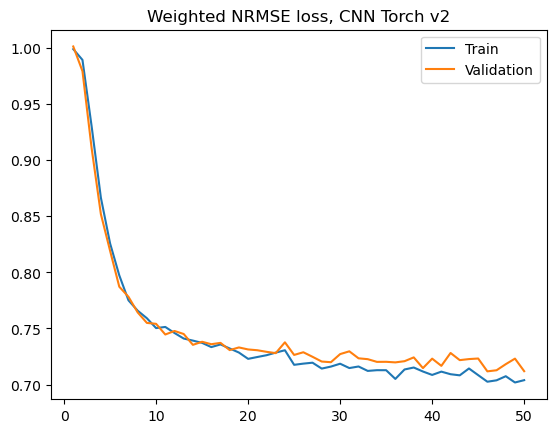

In [16]:
plot_losses(num_epochs, train_losses, val_losses, f"CNN Torch {VERSION}")

In [23]:
## FOR PLOTTING 

def skill(fit, true):
    
    skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
    # Check where true variance really small!
    
    return skill

def return_plot_skill(fit, true, model):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    skill_u = skill(fit[:,0,:,:], true[:,0,:,:])
    skill_v = skill(fit[:,1,:,:], true[:,1,:,:])
    
    data = [skill_u, skill_v]
    nd = len(data)
    titles = ['u', 'v']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*3), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Skill')
        axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
        
    fig.suptitle(f'Skill {model}')
    plt.show()
    
    return skill_u, skill_v

/tmp/ipykernel_3019900/1805208435.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_3019900/1805208435.py:5: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


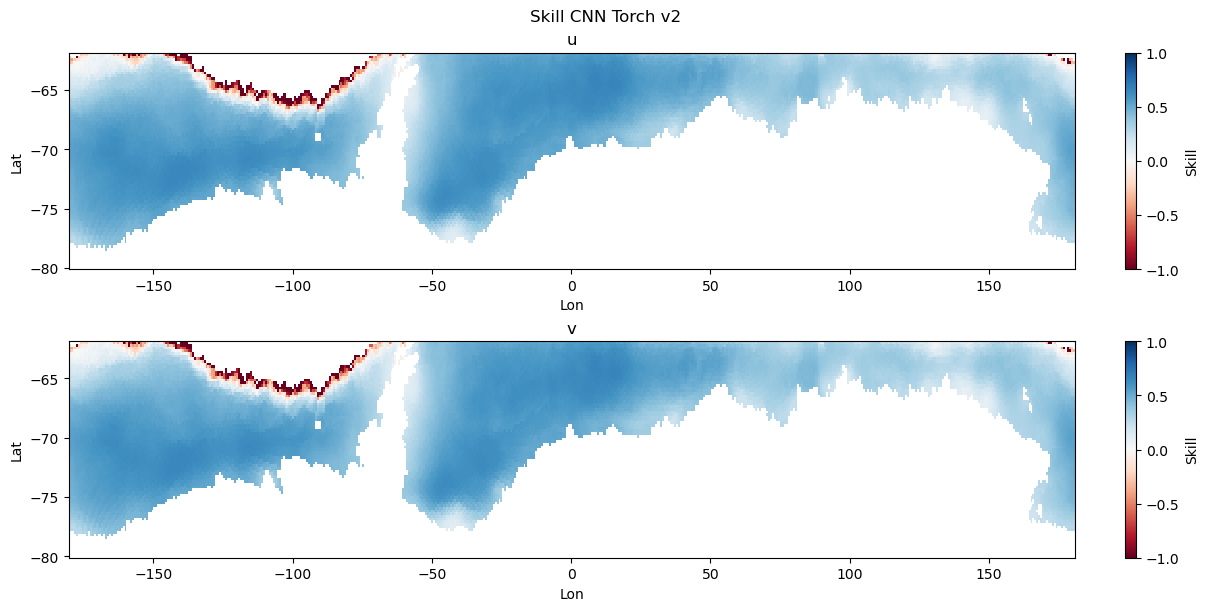

In [24]:
skill_u, skill_v = return_plot_skill(y_pred_cnn_masked, y_true_cnn_masked, f'CNN Torch {VERSION}')

In [ ]:
def correlation(fit, true):
    fit_mean = np.nanmean(fit, axis = 0)
    true_mean = np.nanmean(true, axis = 0)
    
    corr1 = np.nansum((fit - fit_mean) * (true - true_mean), axis = 0)
    corr2 = np.sqrt(np.nansum((fit - fit_mean)**2, axis = 0)) * np.sqrt(np.nansum((true - true_mean)**2, axis = 0))
    
    return corr1 / (corr2)


def return_plot_correlation(fit, true, lat, lon, model):

    vmin = -.1
    vmax = .1
    cmap = plt.cm.RdBu
    
    corr_u = correlation(fit[:,0,:,:], true[:,0,:,:])
    corr_v = correlation(fit[:,1,:,:], true[:,1,:,:])
    
    data = [corr_u, corr_v]
    nd = len(data)
    titles = ['zonal ice velocity ', 'meridional ice velocity']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*3), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Correlation')
        axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')
        
    fig.suptitle(f'Correlation {model}', fontweight = 'bold')

    # # Save plot
    # fnam = f'{model}_correlation.jpeg'
    # plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')
    
    return corr_u, corr_v

/tmp/ipykernel_1187913/3835331741.py:2: RuntimeWarning: Mean of empty slice
  fit_mean = np.nanmean(fit, axis = 0)
/tmp/ipykernel_1187913/3835331741.py:3: RuntimeWarning: Mean of empty slice
  true_mean = np.nanmean(true, axis = 0)
/tmp/ipykernel_1187913/3835331741.py:8: RuntimeWarning: invalid value encountered in divide
  return corr1 / (corr2)


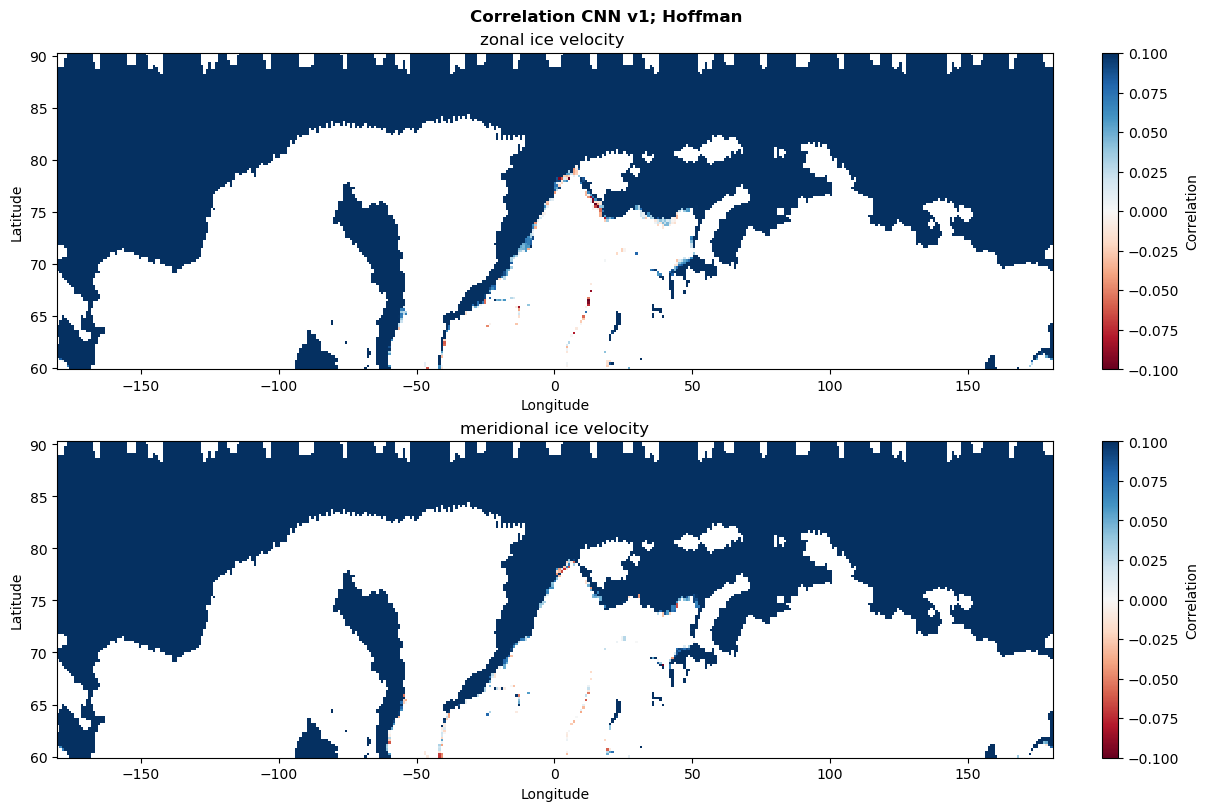

In [ ]:
corr_u, corr_v = return_plot_correlation(y_pred_cnn_masked, y_true_cnn_masked, lat, lon, f"CNN Torch {VERSION}")

In [ ]:
# dataplt = [np.nanmean(rt, axis = 0), np.nanvar(rt, axis = 0),]
# nd = len(dataplt)
# titles = ['Normalized Uncertainty Mean', 'Normalized Uncertainty Variance']

# fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)

# for i in range(nd):
#     pcm = axs[i].pcolormesh(lon, lat, dataplt[i])
#     fig.colorbar(pcm, ax=axs[i])
#     axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')

# fig.suptitle(r'Product Uncertainty', fontweight = 'bold')

# # # Save plot
# # fnam = f'UncPlot.jpeg'
# # plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

# plt.show()